In [1]:
import cv2 as cv
import cv2
import numpy as np
import random 
import matplotlib.pyplot as plt

def show_image(img):
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def show_comparison_image(img1, img2):
    plt.figure()
    plt.subplot(121)
    plt.imshow(img1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(img2)
    plt.xticks([]), plt.yticks([])
    plt.show()

    
def filter_ratio_matches(matches, kp1, kp2, ratio=0.7):
    new_kp1, new_kp2, new_matches = [], [], []
    ctr = 0
    for i, (m, n) in enumerate(matches):  #
        if m.distance < ratio * n.distance:
            new_kp1.append(kp1[m.queryIdx])
            new_kp2.append(kp2[m.trainIdx])
            new_matches.append([cv.DMatch(ctr, ctr, m.distance)])
            ctr += 1
    return new_matches, new_kp1, new_kp2

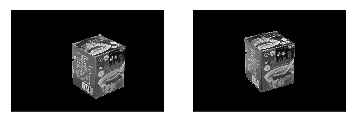

In [2]:
img1 = cv.imread("data/Mesona1.JPG",0)
img2 = cv.imread("data/Mesona2.JPG",0)

show_img1 = cv.cvtColor(img1, cv.COLOR_GRAY2RGB)
show_img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
show_comparison_image(show_img1, show_img2)

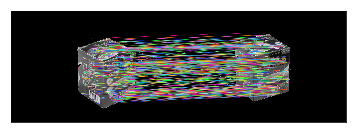

In [3]:

# Make SIFT Object
sift = cv.xfeatures2d.SIFT_create()

# Detect Local Descriptors and Keypoints
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Brute Force Local Descripter Matcher
bf = cv.BFMatcher(cv.NORM_L2)

# For each local descriptor des1, find 2 best correspondence from des 2
matches = bf.knnMatch(des1, des2, k=2)  # Think of it just finding a cluster of ssd.

matches, kp1, kp2 = filter_ratio_matches(matches, kp1, kp2, 0.75)

output_2 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, flags=2)

show_image(output_2)

In [4]:
def normalize2dpts(in_pts):
    centroid = np.array([in_pts[:,0].mean(), in_pts[:,1].mean(),0])
    pts = in_pts - centroid
    
    meandist = np.sqrt(pts[:,0]**2 + pts[:,1]**2).mean()
    scale = np.sqrt(2)/(meandist)
    
    T = np.array([[scale, 0, -scale*centroid[0]],
                  [0, scale, -scale*centroid[1]],
                  [0,0,1]])
    
    newpts = np.dot(T, in_pts.transpose()).transpose()
#     result = np.dot(np.linalg.inv(T), newpts.transpose()).transpose()
    return newpts, T

In [5]:
def fundmat(in_points_in_img1, in_points_in_img2):
    # normalize
    points_in_img1, T1 = normalize2dpts(in_points_in_img1)
    points_in_img2, T2 = normalize2dpts(in_points_in_img2)
    
    # Solve for A
    s = points_in_img1.shape[0]
    
    A = np.zeros((s, 9))
    for index in range(0, s):
        x, y = points_in_img1[index][0], points_in_img1[index][1]
        tx, ty = points_in_img2[index][0], points_in_img2[index][1]
        A[index] = [tx*x, tx*y, tx, ty*x, ty*y, ty, x,y,1]

    u, s, v = np.linalg.svd(A)
    F = v[-1].reshape(3, 3)  # eigenvector with the least eigenvalue
    
    u, s, v = np.linalg.svd(F)
    s[2] = 0
    F = np.dot(np.dot(u,np.diag(s)),v)

    # denormalize
    F = np.dot(np.dot(T2.transpose(),F),T1)

    return F/F[2,2]

def computeEpipoleLines(F, pts):
    lines = np.dot(F, pts.transpose()).transpose()
    n = np.sqrt(lines[:,0]**2 + lines[:,1]**2).reshape(-1,1)
    return lines / n * -1

def transformPtsToArrayPts(kp1, kp2, matches):
    tup_matches_kp1 = [kp1[dt[0].queryIdx].pt for dt in matches]
    tup_matches_kp2 = [kp2[dt[0].trainIdx].pt for dt in matches]
    matches_kp1 = np.array([[h for h in kp] + [1] for kp in tup_matches_kp1])
    matches_kp2 = np.array([[h for h in kp] + [1] for kp in tup_matches_kp2])
    return matches_kp1, matches_kp2

#http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT11/node12.html
#https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py
def computeEpipole(F):
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

def calculateSampsonDistance(matches_kp1, matches_kp2, F):
    Fx1 = np.dot(F,matches_kp1.transpose())
    Fx2 = np.dot(F.transpose(),matches_kp2.transpose())
    denom = (Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2).reshape(-1,1)
    
#     print(denom.shape)
    err = (np.diag(np.dot(matches_kp2,np.dot(F,matches_kp1.transpose())))**2)
    err = err.reshape(-1,1) / denom
    return err

def randomPartition(n,n_data):
    """return n random rows of data (and also the other len(data)-n rows)"""
    all_idxs = np.arange( n_data )
    np.random.shuffle(all_idxs)
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2


In [25]:
def ransac(matches_kp1, matches_kp2, s=8, threshold=3,
           maxIterations=5000, returnMatches=False,
           inlierThreshold=50,confidence=0.99):
    
    cnt_matches = matches_kp1.shape[0]
    best_fit = []
    best_error = np.Infinity
    best_kp1, best_kp2 = [], []
    best_total = 0
    
    k= maxIterations
    for iter in range(k):
        maybe_idxs, test_idxs = randomPartition(s, cnt_matches)
        # Take s data points
        data_p1 = np.take(matches_kp1, maybe_idxs, axis=0)
        data_p2 = np.take(matches_kp2, maybe_idxs, axis=0)
        # Fit a fundamental matrix
        F = fundmat(data_p1, data_p2)
        
        # Test the current fundamental matrix
        test_p1 = np.take(matches_kp1, test_idxs, axis=0)
        test_p2 = np.take(matches_kp2, test_idxs, axis=0)
        errs = calculateSampsonDistance(test_p1, test_p2, F)
        
        # Initialize Current Matches
        current_p1, current_p2 = [], []
        current_total = 0
    

        
        inlier_indices = [errs[:,0] < threshold];
        current_p1 = np.append(data_p1, test_p1[inlier_indices], axis=0)
        current_p2 = np.append(data_p2, test_p2[inlier_indices], axis=0)
        current_total = current_p1.shape[0]
        
        if current_total > best_total and current_total >= inlierThreshold:
            better_fit = fundmat(current_p1, current_p2)
            better_err = calculateSampsonDistance(current_p1, current_p2, F)
            
            if (best_error > better_err.mean()):
                best_fit = better_fit
                best_kp1 = current_p1
                best_kp2 = current_p2
                best_total = current_p1.shape[0]
                
                # # we are done in case we have enough inliers
                r = current_total / cnt_matches
                nk = np.log(1-confidence)/np.log(1-pow(r,s))
                if iter > nk:
                    break
                
    
        
    print(str(best_total) + "/" + str(cnt_matches))
    if returnMatches:
        return best_fit, best_kp1, best_kp2
    
    return best_fit


matches_kp1, matches_kp2 = transformPtsToArrayPts(kp1, kp2, matches)
    
best_fit, best_kp1, best_kp2 = ransac(matches_kp1,matches_kp2, returnMatches=True)
print(best_fit)

461/515
[[ 6.33569844e-09 -1.46832268e-06 -1.49729345e-03]
 [ 4.98287441e-07 -1.36318050e-07  1.80544345e-02]
 [ 5.75183796e-04 -1.70076673e-02  1.00000000e+00]]


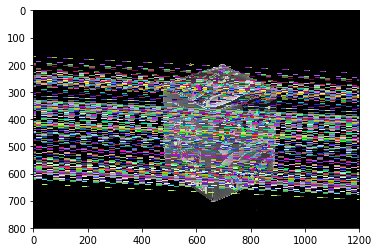

True

In [23]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    t_pts1= np.int32(pts1)
    t_pts2= np.int32(pts2)
    for r,pt1,pt2 in zip(lines,t_pts1,t_pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1[0:2]),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2[0:2]),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = computeEpipoleLines(best_fit.transpose(), best_kp2)
img5,img6 = drawlines(img1,img2,lines1,best_kp1,best_kp2)
plt.imshow(img5)
plt.show()
cv2.imwrite("1.jpg", img5)
cv2.imwrite("2.jpg", img6)